# Overview
**This project intended to predict max horsepower using different characteristics about a vehicle.** I first scraped COBB Tuning's public dyno results database for dyno runs and information about the car being run. I organized this scraped data and uploaded it to Kaggle for public use, then I analyzed it using regression techniques. Using keyword features built from the column describing the car, I created and fit many models and outperformed the mean baseline by a significant margin.

# Findings
## 1. As boost PSI is increased, max horsepower increases.
## 2. As fuel octane is increased, max horsepower increases.
## 3. Including the stock hosepower as a feature dramatically increases model performance.
The dataset includes various cars with different stock horsepower. Cars have varying performance at stock and that needs to be controlled-for in our model.
## 4. For unknown reasons, cars with engine computer tuning do not have higher horsepower than cars without it.

# Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

import wrangle
import model

# Wrangle
## My Work - Bottom Line Up Front
1. Scraped data from the database located at dyno.cobbtuning.com
2. Organized the data into two files using Python/Pandas
3. Uploaded both files here: https://www.kaggle.com/paxtonjacob/cobb-tuning-dyno-data
4. Split the year-make-model column in car_info.csv into three columns using Regular Expressions (REGEX)
5. Drop rows with null RPM values or null Boost values in dyno_runs.csv
    * Dropped the AFR column entirely but kept Boost as a column based on project needs
6. Created 'psi' and 'octane' features using REGEX in car_info
7. Imputed nulls in car_info 'psi' using the max values in dyno_runs 'Boost' for each run
8. Filled nulls in car_info 'octane' using the most common octane value (92)
9. Created new column for each car_info for the max horsepower in each dyno_runs run
10. Created new column for each car_info 'car_model' stock horsepower
11. Created 'tuned_cpu' feature based on keywords and domain knowledge
12. Split the data into train (50% of observations), validate (30%), and test (20%) for exploration
13. Further prepared the data for modeling by isolating the target from the features and scaling features

## Implementation

In [2]:
# acquire, wrangle data for exploration
info_train, runs_train = wrangle.prep_explore()

# Explore
## My Work - Bottom Line Up Front
1. Limited the data to a single make and model with consistent stock horsepower (Subaru WRX STI, most common make and model in our dataset)
2. Plotted histograms for our features
3. Plotted correlation heatmap for our features
4. Conducted statistical testing to verify our features for modeling
    * Correlation test for boost PSI and max horsepower
    * Correlation test for fuel octane and max horsepower
    * T-test to compare cars with tuned CPUs and cars without tuned CPUs in terms of max horsepower
5. Eliminated our tuned_cpus feature because it did not pass our confidence interval
6. Kept boost PSI and fuel octane as features because they were significantly correlated with max horsepower

## Implementation
**1. Limited the data to a single make and model with consistent stock horsepower (Subaru WRX STI, most common make and model in our dataset)**

In [3]:
# limit data to WRX STI
sti_info = info_train[info_train.car_model.str.contains('STI')]
# check work
sti_info.head()

,run,name,specs,car_make,car_model,stock_hp,psi,octane,tuned_cpu,hp
3263,4208,Ahmed Belazi,"COBB Tuning Accessport, COBB Tuning Turboback,...",Subaru,2011 Impreza WRX STI,305,15.0,92,True,296.0
3271,4261,Sean Kim,"COBB Tuning Accessport, Perrin Turbobck, Coswo...",Subaru,2011 Impreza WRX STI,305,19.5,92,True,317.0
3237,3827,Matt Songer,"COBB Tuning AccessPORT, Invidia Catted Downpip...",Subaru,2011 Impreza WRX STI,305,18.0,92,True,277.0
3541,2703,COBB Tuning,MAF - Sport,Subaru,2011 Impreza WRX STI Hatch,305,15.0,92,False,262.0
4010,4940,Ho Joon Lee,"COBB Tuning Accessport, Nameless TBE, Tial 38m...",Subaru,2013 Impreza WRX STI,305,15.0,92,True,49.0


**2. Plotted histograms for our features**

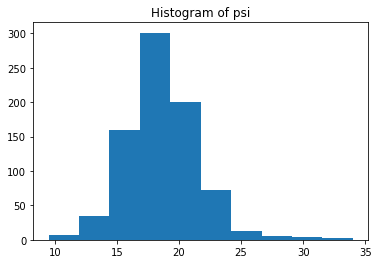

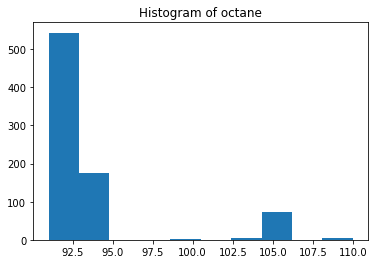

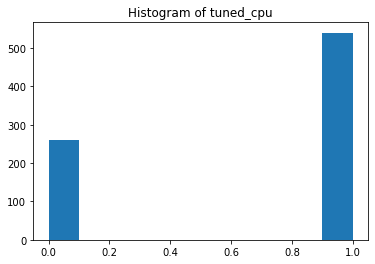

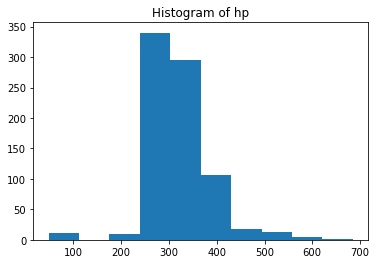

In [4]:
# choose columns for exploration
sti_info = sti_info[['psi','octane','tuned_cpu','hp']].astype('float')
# plot histograms
for col in sti_info.columns:
    plt.hist(sti_info[col])
    plt.title('Histogram of ' + col)
    plt.show()

**3. Plotted correlation heatmap for our features**

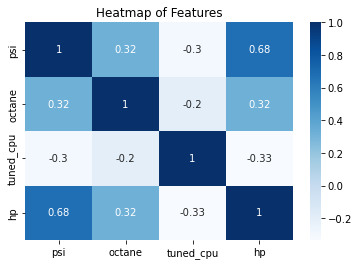

In [5]:
# check correlation heatmap
sns.heatmap(sti_info.corr(), cmap='Blues', annot=True)
plt.title('Heatmap of Features')
plt.show()

**4. Conducted statistical testing to verify our features for modeling**

## Does Boost PSI Correlate with Horsepower?
- $H_0$: Boost PSI does not correlate with horsepower.
- $H_a$: Boost PSI correlates with horsepower.
- Confidence Interval: 95%

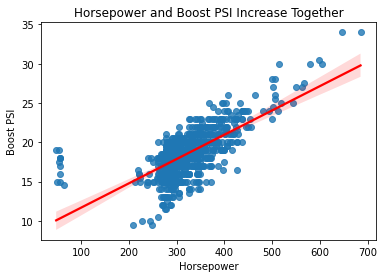

Boost PSI increases as horsepower increases, with 95% confidence.
Slope: 0.030947665013757102
p-value: 2.1634495339588766e-108


In [6]:
# check correlation of horsepower and boost PSI
sns.regplot(sti_info.hp, sti_info.psi, line_kws={'color':'red'})
plt.title('Horsepower and Boost PSI Increase Together')
plt.xlabel('Horsepower')
plt.ylabel('Boost PSI')
plt.show()

slope, _, _, p, _ = stats.linregress(sti_info.hp, sti_info.psi)
if slope > 0 and p < .05:
    print('Boost PSI increases as horsepower increases, with 95% confidence.')
elif slope < 0 and p < .05:
    print('As boost PSI decreases, horsepower increases, with 95% confidence.')
else:
    print('Test does not pass 95% confidence interval. Boost PSI and horsepower are not correlated.')
    
print('Slope:', slope)
print('p-value:', p)

## Does Fuel Octane Correlate with Horsepower?
- $H_0$: Fuel octane does not correlate with horsepower.
- $H_a$: Fuel octane correlates with horsepower.
- Confidence Interval: 95%

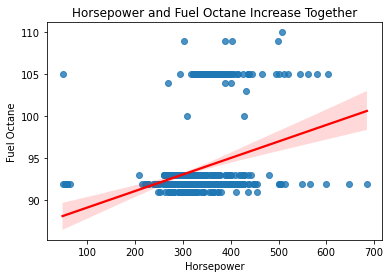

Fuel octane increases as horsepower increases, with 95% confidence.
Slope: 0.01963325852470509
p-value: 1.2133858273336407e-20


In [7]:
# check correlation of horsepower and fuel octane
sns.regplot(sti_info.hp, sti_info.octane, line_kws={'color':'red'})
plt.title('Horsepower and Fuel Octane Increase Together')
plt.xlabel('Horsepower')
plt.ylabel('Fuel Octane')
plt.show()

slope, _, _, p, _ = stats.linregress(sti_info.hp, sti_info.octane)

if slope > 0 and p < .05:
    print('Fuel octane increases as horsepower increases, with 95% confidence.')
elif slope < 0 and p < .05:
    print('As fuel octane decreases, horsepower increases, with 95% confidence.')
else:
    print('Test does not pass 95% confidence interval. Fuel octane and horsepower are not correlated.')

print('Slope:', slope)
print('p-value:', p)

## Do Cars with Tuned CPUs Have Higher Horsepower?
- $H_0$: Cars with tuned CPUs do not have higher horsepower.
- $H_a$: Cars with tuned CPUs have higher horsepower.
- Confidence Interval: 95%

In [8]:
sti_info

,psi,octane,tuned_cpu,hp
3263,15.0,92.0,1.0,296.0
3271,19.5,92.0,1.0,317.0
3237,18.0,92.0,1.0,277.0
3541,15.0,92.0,0.0,262.0
4010,15.0,92.0,1.0,49.0
...,...,...,...,...
3161,16.0,92.0,1.0,291.0
1561,20.0,93.0,0.0,301.0
3253,16.0,92.0,1.0,297.0
3184,20.0,93.0,1.0,307.0


In [9]:
# conduct t-test
t, p = stats.mannwhitneyu(sti_info[sti_info.tuned_cpu.astype('bool')].hp,
                          sti_info[~sti_info.tuned_cpu.astype('bool')].hp,
                          alternative='greater')

if t > 0 and p < .05:
    print('Cars with tuned CPUs have higher horsepower, with 95% confidence.')
else:
    print('Results do not breach 95% confidence interval, cars with tuned CPUs do not have higher horsepower.')

Results do not breach 95% confidence interval, cars with tuned CPUs do not have higher horsepower.


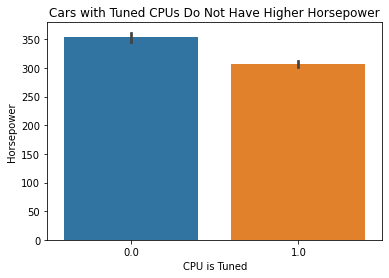

In [10]:
# plot bar chart
sns.barplot(data=sti_info, x='tuned_cpu', y='hp')
plt.title('Cars with Tuned CPUs Do Not Have Higher Horsepower')
plt.xlabel('CPU is Tuned')
plt.ylabel('Horsepower')
plt.show()

**5. Eliminated our tuned_cpus feature because it did not pass our confidence interval (done in Model)**

**6. Kept boost PSI and fuel octane as features because they were significantly correlated with max horsepower (done in Model)**

# Model
## My Work - Bottom Line Up Front
1. Ran our initial features (boost PSI, fuel octane) through one model (Ordinary Least Squares [OLS])
2. Plotted residuals for our Minimum Viable Product (MVP) model
3. Evaluated our MVP model performance for RMSE, r^2 explained variance, and more using our train and validate splits
    * Compared performance to the mean value of train as our predictions (baseline)
    * Outperformed the baseline
4. Added stock horsepower as a feature in our post-MVP iteration
5. Built, fit more models and hyperparameter combinations on our three features
    * Lasso+LARS, GLM, and Polynomial OLS
6. Evaluated our post-MVP model performance for RMSE and r^2 explained variance using our train and validate splits
7. Selected our best-performing model
8. Plotted residuals for our best model
9. Evaluated our best model on the sequestered test split

## Implementation
Note: Steps 1-3 are the MVP process. We will start with Step 4.

**4. Added stock horsepower as a feature in our post-MVP iteration**

In [11]:
# acquire, prep, split, isolate for model
X_train, y_train, X_validate, y_validate, X_test, y_test = wrangle.prep_model()

**5. Built, fit more models and hyperparameter combinations on our three features**

In [12]:
# prepare train and validate for regression shotgun
y_train = pd.DataFrame(y_train).rename(columns={'hp':'actuals'})
y_validate = pd.DataFrame(y_validate).rename(columns={'hp':'actuals'})
# run the regression shotgun
y_train, y_validate = model.regression_shotgun(X_train, y_train, X_validate, y_validate)
# check work
y_validate.head()

,actuals,mean_bl,median_bl,ols_preds,lars_0.0001_preds,lars_0.001_preds,lars_0.01_preds,lars_0.1_preds,lars_1_preds,lars_10_preds,...,glm_p3a0.1_preds,glm_p3a1_preds,glm_p3a10_preds,glm_p3a100_preds,glm_p3a1000_preds,lm_pf_2_preds,lm_pf_3_preds,lm_pf_4_preds,lm_pf_5_preds,lm_pf_6_preds
1285,299.0,326.894207,304.0,318.719849,318.722038,318.741742,318.938786,320.909225,329.924514,328.913505,...,328.913505,328.913505,328.913505,328.913505,328.913505,300.894291,297.472794,291.735217,295.641207,296.937087
2780,296.0,326.894207,304.0,301.888066,301.890030,301.907704,302.084442,303.851821,322.509652,328.913505,...,328.913505,328.913505,328.913505,328.913505,328.913505,305.371334,291.498907,285.887752,288.357145,290.370292
1700,318.0,326.894207,304.0,245.116738,245.126143,245.210785,246.057209,254.521444,315.094790,328.913505,...,328.913505,328.913505,328.913505,328.913505,328.913505,239.727767,230.479723,251.344555,244.936050,241.293144
1552,276.0,326.894207,304.0,332.028088,332.027821,332.025419,332.001398,331.761195,329.924514,328.913505,...,328.913505,328.913505,328.913505,328.913505,328.913505,323.281844,312.888260,303.973276,308.319957,306.736114
1748,353.0,326.894207,304.0,327.466589,327.467541,327.476116,327.561859,328.419290,330.983780,328.913505,...,328.913505,328.913505,328.913505,328.913505,328.913505,315.092154,312.439877,307.789061,311.479359,314.090046


**6. Evaluated our post-MVP model performance for RMSE and r^2 explained variance using our train and validate splits**

In [13]:
# check RMSE and R^2 value for each model on train and validate
running_df = model.y_df_RMSE_r2(y_train, y_validate)
# check results
running_df.sort_values(by='Validate_r2', ascending=False).head()

,Model,Train_RMSE,Validate_RMSE,Train_r2,Validate_r2
45,lm_pf_4_preds,50.659167,60.861762,0.734984,0.613175
43,lm_pf_2_preds,58.427301,64.294286,0.647476,0.568312
27,glm_p2a0.0001_preds,92.670653,67.384360,0.113168,0.525820
44,lm_pf_3_preds,54.328950,67.447989,0.695197,0.524924
19,glm_p1a0.0001_preds,69.064539,68.910583,0.507431,0.504097


**7. Selected our best-performing model: OLS with Polynomial Features (second model in above dataframe)**

**8. Plotted residuals for our best model**

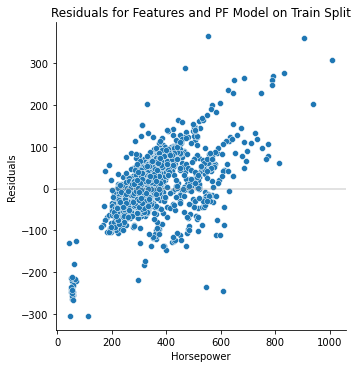

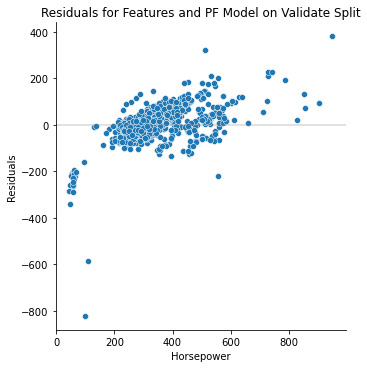

In [14]:
# show residuals for best model
# calculate residuals
pf_train_residuals = y_train['actuals'] - y_train['lm_pf_2_preds']
pf_validate_residuals = y_validate['actuals'] - y_validate['lm_pf_2_preds']

# plot residuals for train split
sns.relplot(x=y_train['actuals'], y=pf_train_residuals)
plt.title('Residuals for Features and PF Model on Train Split')
plt.axhline(y=0, c='gray', alpha=.3)
plt.xlabel('Horsepower')
plt.ylabel('Residuals')
plt.show()

# plot residuals for validate split
sns.relplot(x=y_validate['actuals'], y=pf_validate_residuals)
plt.title('Residuals for Features and PF Model on Validate Split')
plt.axhline(y=0, c='gray', alpha=.3)
plt.xlabel('Horsepower')
plt.ylabel('Residuals')
plt.show()

**9. Evaluated our best model on the sequestered test split**

In [15]:
lm = LinearRegression(normalize=True) # Create linear regression model
# Create polynomial variables
X_train_pf = PolynomialFeatures(degree=2).fit_transform(X_train)
X_test_pf = PolynomialFeatures(degree=2).fit(X_train).transform(X_test)
# Make predictions on polynomial variables
train_predictions = lm.fit(X_train_pf, y_train.actuals).predict(X_train_pf)
test_predictions = lm.fit(X_train_pf, y_train.actuals).predict(X_test_pf)

In [16]:
# Evaluate!
rmse_train = mean_squared_error(y_train.actuals, train_predictions) ** 0.5
rmse_test = mean_squared_error(y_test, test_predictions) ** 0.5
r2_train = r2_score(y_train.actuals, train_predictions)
r2_test = r2_score(y_test, test_predictions)

In [17]:
# print results
print(f'Train: RMSE of {int(rmse_train)} horsepower, explained variance of {round(r2_train * 100, 1)}%.')
print(f'Test: RMSE of {int(rmse_test)} horsepower, explained variance of {round(r2_test * 100, 1)}%.')

Train: RMSE of 58 horsepower, explained variance of 64.7%.
Test: RMSE of 69 horsepower, explained variance of 47.1%.


# Conclusion
## Through keyword engineering and statistical testing, I was able to create features that significantly improved prediction performance of our models
## Scraping and analyzing this data showed that boost PSI and fuel octane correlate with max horsepower
## Additional analysis may yield individual horsepower increases on a part-to-part basis